## IMA205 Challenge 2025 - Left Ventricle Segmentation (Partial Implementation)


In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import os
from tqdm import tqdm  # for a progress bar
from collections import Counter

import nibabel as nib

import scipy.ndimage as ndi

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from skimage.measure import find_contours
from scipy.spatial.distance import cdist

In [9]:
# Load the NIfTI file
img_test = nib.load('Dataset/Test/102/102_ED.nii')  
img_test_seg = nib.load('Dataset/Test/102/102_ED_seg.nii')
# Get the image data as a NumPy array
data_test = img_test.get_fdata()
data_test_seg = img_test_seg.get_fdata()

# Print shape
print("Shape:", data_test.shape)
print("Shape:", data_test_seg.shape)

Shape: (174, 208, 17)
Shape: (174, 208, 17)


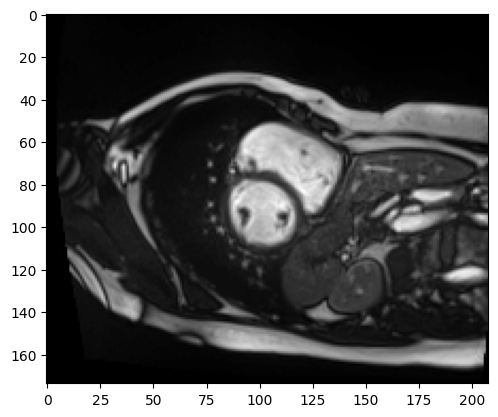

In [10]:
plt.imshow(data_test[:, :, 5], cmap='gray')

------

**Normal Version**

In [11]:
import numpy as np
from skimage.feature import canny
from skimage.transform import hough_circle, hough_circle_peaks
import nibabel as nib
import matplotlib.pyplot as plt
from skimage.draw import circle_perimeter


In [12]:

def compute_seed_from_ed_es(data_ED, data_ES, hough_radii_range=(15, 50)):
    """
    Compute initial seed point from the same slice in ED and ES 3D images.
    Args:
        data_ED: 3D NumPy array [height, width, slices] for End Diastole.
        data_ES: 3D NumPy array [height, width, slices] for End Systole.
        hough_radii_range: range of radii to test in Hough circle detection.
    Returns:
        slice_idx: index of the used slice.
        seed_point: (x, y) coordinates of the detected center.
        radius: radius of the detected LV cavity.
    """
    slice_idx = data_ED.shape[2] // 2
    slice_ED = data_ED[:, :, slice_idx]
    slice_ES = data_ES[:, :, slice_idx]

    # Difference image
    diff_image = np.abs(slice_ED - slice_ES)
    diff_image = (diff_image - diff_image.min()) / (diff_image.max() - diff_image.min())

    # Edge detection
    edges = canny(diff_image, sigma=2)

    # Hough Transform
    hough_radii = np.arange(hough_radii_range[0], hough_radii_range[1], 1)
    hough_res = hough_circle(edges, hough_radii)
    accums, cx, cy, radii = hough_circle_peaks(hough_res, hough_radii, total_num_peaks=1)

    if len(cx) > 0:
        seed_point = (cx[0], cy[0])  # (x, y)
        return slice_idx, seed_point, radii[0]
    else:
        return slice_idx, None, None


In [ ]:
def plot_heart_slice_with_seed(data_ED, slice_idx, seed_point, radius):
    """
    Plota a fatia do coração com o ponto semente e o círculo detectado.
    """
    import matplotlib.pyplot as plt
    from skimage.draw import circle_perimeter

    img_slice = data_ED[:, :, slice_idx]

    fig, ax = plt.subplots(figsize=(6, 6))
    ax.imshow(img_slice, cmap='gray')
    ax.set_title(f"Slice {slice_idx} with Seed Point")

    if seed_point is not None:
        cx, cy = int(seed_point[0]), int(seed_point[1])
        rr, cc = circle_perimeter(cy, cx, int(radius), shape=img_slice.shape)
        img_overlay = img_slice.copy()
        img_overlay[rr, cc] = img_overlay.max()  # destaca o círculo
        ax.plot(cx, cy, 'ro', label='Seed Point')
        ax.imshow(img_overlay, cmap='gray')

    ax.legend()
    plt.axis('off')
    plt.show()

    return


Slice index: 4
Seed point: (59, 110)


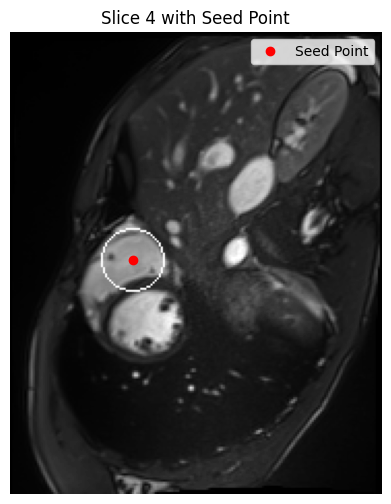

In [14]:
import nibabel as nib

# Carregar os dois volumes
img_ed = nib.load('Dataset/Test/107/107_ED.nii')
img_es = nib.load('Dataset/Test/107/107_ES.nii')
data_ED = img_ed.get_fdata()
data_ES = img_es.get_fdata()

# Obter ponto semente
slice_idx, seed, radius = compute_seed_from_ed_es(data_ED, data_ES)

print("Slice index:", slice_idx)
print("Seed point:", seed)
plot_heart_slice_with_seed(data_ED, slice_idx, seed, radius)

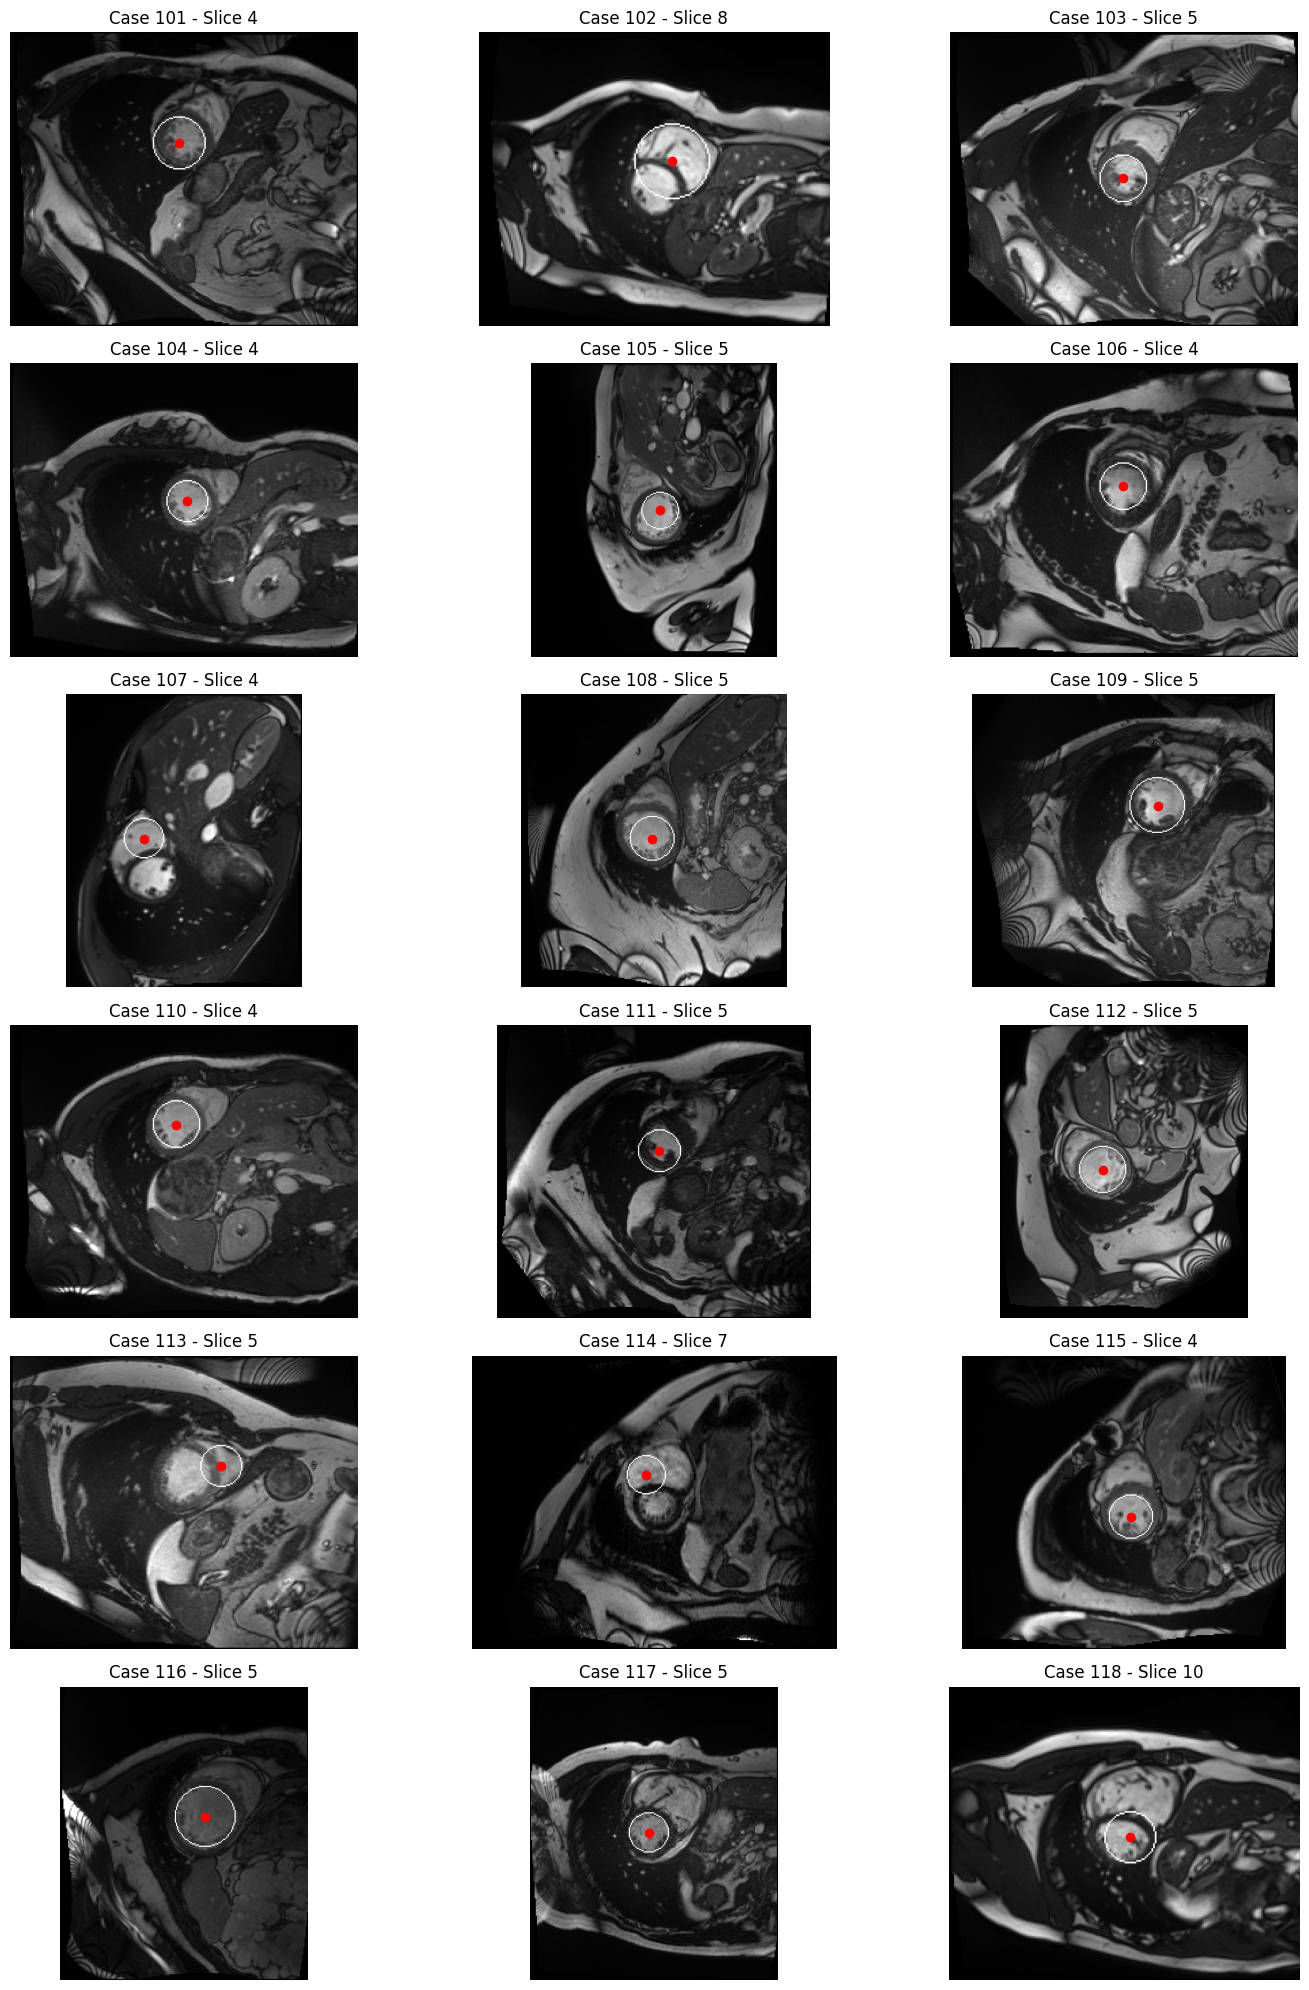

In [15]:
fig, axes = plt.subplots(6, 3, figsize=(15, 20))
axes = axes.ravel()

for i, case_id in enumerate(range(101, 119)):
    try:
        img_ed = nib.load(f'Dataset/Test/{case_id}/{case_id}_ED.nii')
        img_es = nib.load(f'Dataset/Test/{case_id}/{case_id}_ES.nii')
        data_ED = img_ed.get_fdata()
        data_ES = img_es.get_fdata()

        slice_idx, seed, radius = compute_seed_from_ed_es(data_ED, data_ES)
        slice_img = data_ED[:, :, slice_idx]

        axes[i].imshow(slice_img, cmap='gray')
        axes[i].set_title(f"Case {case_id} - Slice {slice_idx}")
        axes[i].axis('off')

        if seed is not None:
            cx, cy = int(seed[0]), int(seed[1])
            rr, cc = circle_perimeter(cy, cx, int(radius), shape=slice_img.shape)
            slice_img = slice_img.copy()
            slice_img[rr, cc] = slice_img.max()
            axes[i].imshow(slice_img, cmap='gray')
            axes[i].plot(cx, cy, 'ro')
    except Exception as e:
        axes[i].set_title(f"Case {case_id} - Error")
        axes[i].axis('off')
        print(f"Erro no caso {case_id}: {e}")

plt.tight_layout()
plt.show()

**Histogram matching** (not good)

In [16]:
from skimage.exposure import match_histograms
from skimage.feature import canny
from skimage.transform import hough_circle, hough_circle_peaks
import numpy as np

def compute_seed_from_ed_es_v2(data_ED, data_ES, hough_radii_range=(15, 50), reference_image=None):
    """
    Compute initial seed point from the same slice in ED and ES 3D images.
    Optionally apply histogram transfer using a reference image.
    
    Args:
        data_ED: 3D NumPy array [height, width, slices] for End Diastole.
        data_ES: 3D NumPy array [height, width, slices] for End Systole.
        hough_radii_range: range of radii to test in Hough circle detection.
        reference_image: 2D NumPy array to match histograms against (optional).
    
    Returns:
        slice_idx: index of the used slice.
        seed_point: (x, y) coordinates of the detected center.
        radius: radius of the detected LV cavity.
    """
    slice_idx = data_ED.shape[2] // 2
    slice_ED = data_ED[:, :, slice_idx]
    slice_ES = data_ES[:, :, slice_idx]

    # Apply histogram matching if reference is provided
    if reference_image is not None:
        slice_ED = match_histograms(slice_ED, reference_image)
        slice_ES = match_histograms(slice_ES, reference_image)

    # Difference image
    diff_image = np.abs(slice_ED - slice_ES)
    diff_image = (diff_image - diff_image.min()) / (diff_image.max() - diff_image.min())

    # Edge detection
    edges = canny(diff_image, sigma=2)

    # Hough Transform
    hough_radii = np.arange(hough_radii_range[0], hough_radii_range[1], 2)
    hough_res = hough_circle(edges, hough_radii)
    accums, cx, cy, radii = hough_circle_peaks(hough_res, hough_radii, total_num_peaks=1)

    if len(cx) > 0:
        seed_point = (cx[0], cy[0])  # (x, y)
        return slice_idx, seed_point, radii[0]
    else:
        return slice_idx, None, None


**Equalization** (not good)

In [17]:
from skimage.exposure import equalize_adapthist
from skimage.feature import canny
from skimage.transform import hough_circle, hough_circle_peaks
import numpy as np

def compute_seed_from_ed_es_v2(data_ED, data_ES, hough_radii_range=(15, 50), case_id=None):
    slice_idx = data_ED.shape[2] // 2
    slice_ED = data_ED[:, :, slice_idx]
    slice_ES = data_ES[:, :, slice_idx]

    apply_eq = True

    if apply_eq:
        # Normalizar para [0, 1] antes de aplicar equalize_adapthist
        slice_ED = (slice_ED - slice_ED.min()) / (slice_ED.max() - slice_ED.min())
        slice_ES = (slice_ES - slice_ES.min()) / (slice_ES.max() - slice_ES.min())

        slice_ED = equalize_adapthist(slice_ED, clip_limit=0.03)
        slice_ES = equalize_adapthist(slice_ES, clip_limit=0.03)
        

    # Difference image
    diff_image = np.abs(slice_ED - slice_ES)
    diff_image = (diff_image - diff_image.min()) / (diff_image.max() - diff_image.min())

    # Edge detection
    edges = canny(diff_image, sigma=2)

    # Hough Transform
    hough_radii = np.arange(hough_radii_range[0], hough_radii_range[1], 2)
    hough_res = hough_circle(edges, hough_radii)
    accums, cx, cy, radii = hough_circle_peaks(hough_res, hough_radii, total_num_peaks=1)

    if len(cx) > 0:
        seed_point = (cx[0], cy[0])
        return slice_idx, seed_point, radii[0]
    else:
        return slice_idx, None, None


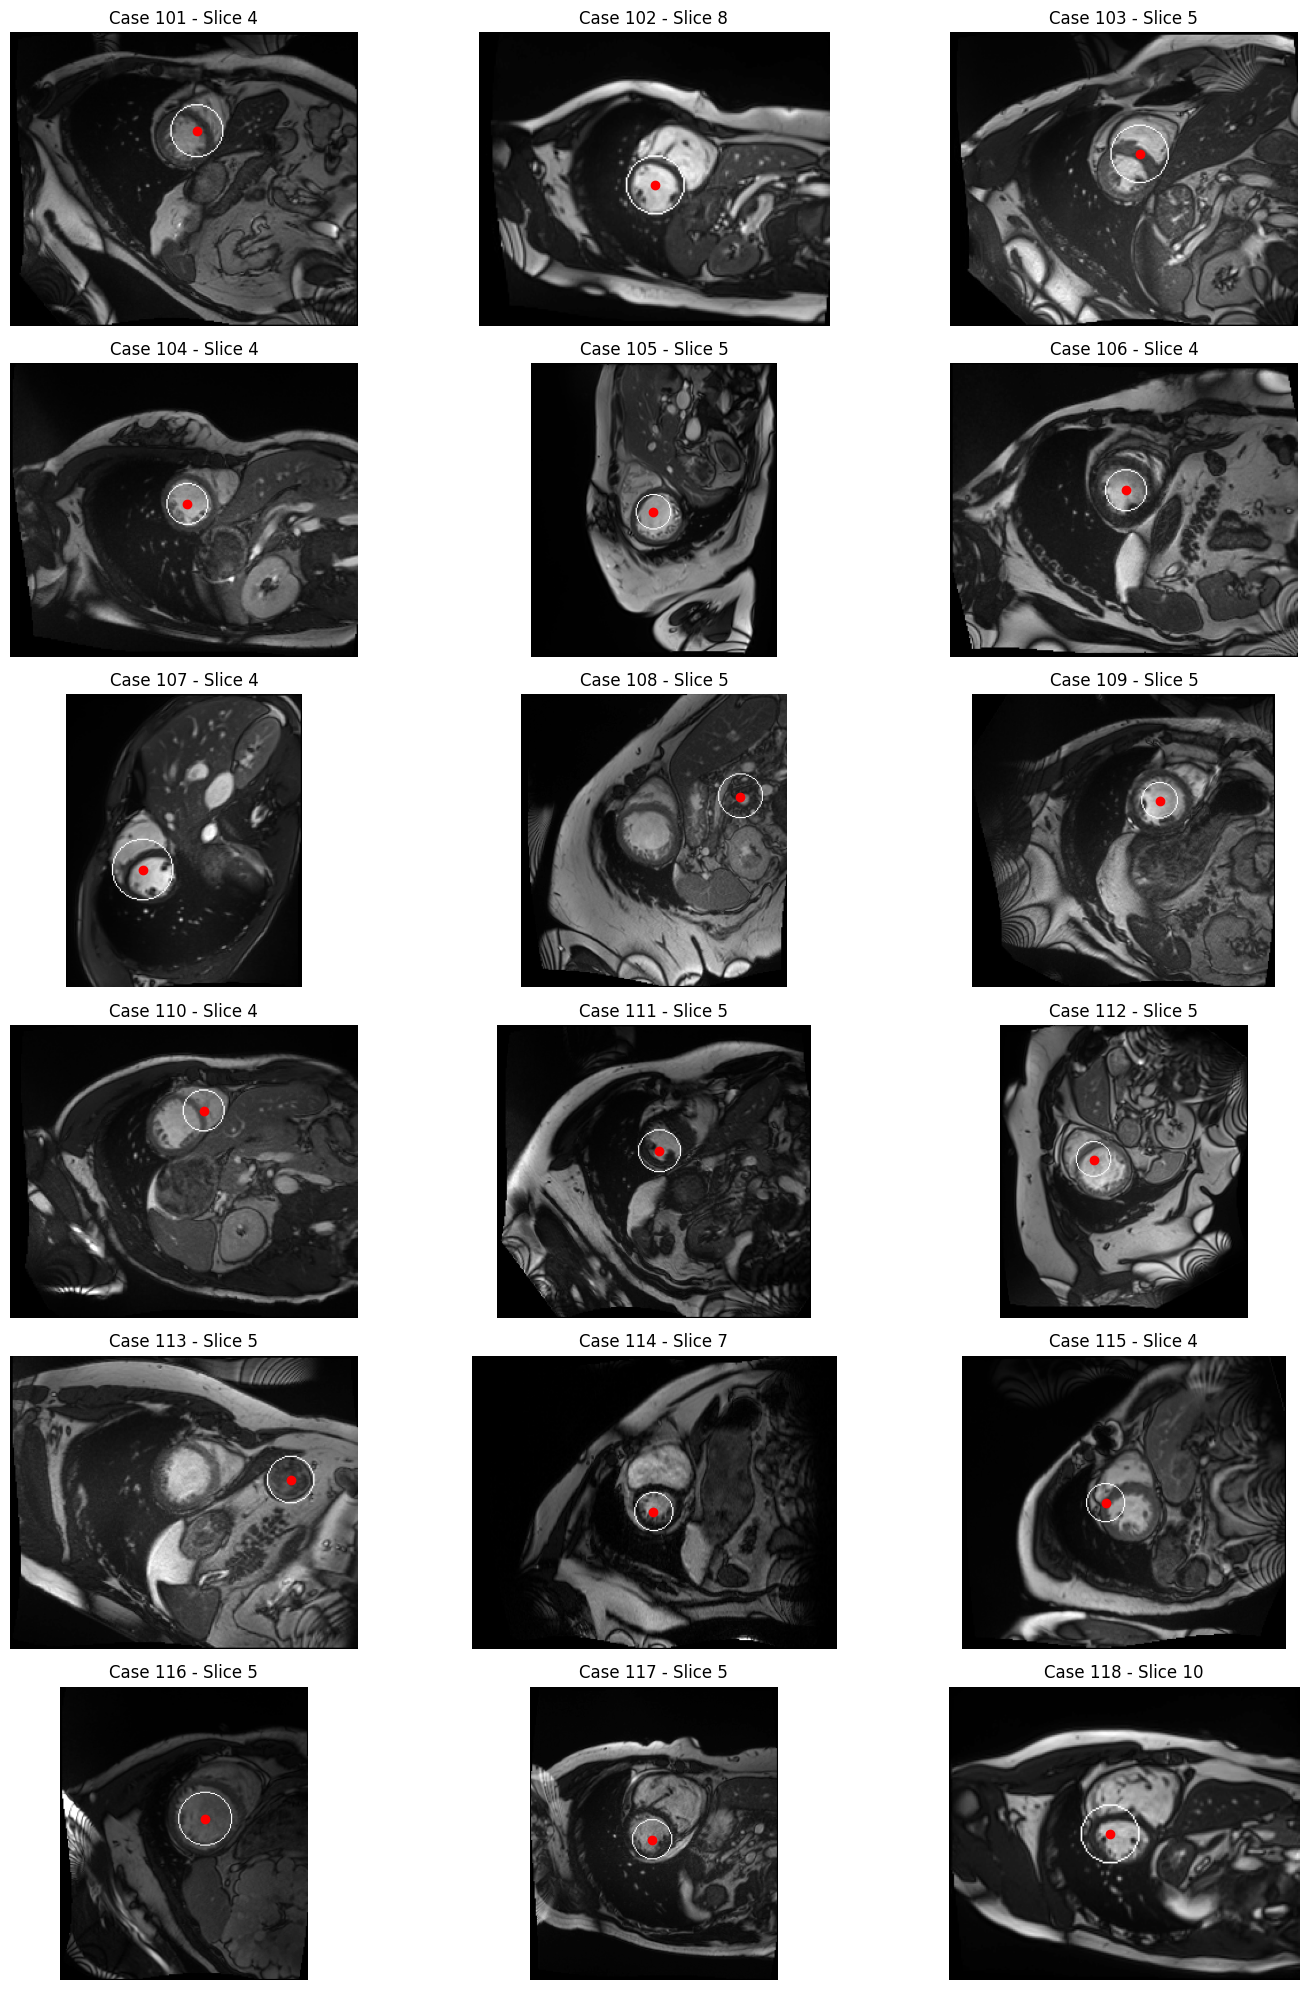

In [18]:
image_ref = nib.load('Dataset/Test/108/108_ED.nii')
data_ref = image_ref.get_fdata()
image_ref_slice = data_ref[:, :, data_ref.shape[2] // 2]

fig, axes = plt.subplots(6, 3, figsize=(15, 20))
axes = axes.ravel()

for i, case_id in enumerate(range(101, 119)):
    try:
        img_ed = nib.load(f'Dataset/Test/{case_id}/{case_id}_ED.nii')
        img_es = nib.load(f'Dataset/Test/{case_id}/{case_id}_ES.nii')
        data_ED = img_ed.get_fdata()
        data_ES = img_es.get_fdata()

        slice_idx, seed, radius = compute_seed_from_ed_es_v2(data_ED, data_ES)
        slice_img = data_ED[:, :, slice_idx]

        axes[i].imshow(slice_img, cmap='gray')
        axes[i].set_title(f"Case {case_id} - Slice {slice_idx}")
        axes[i].axis('off')

        if seed is not None:
            cx, cy = int(seed[0]), int(seed[1])
            rr, cc = circle_perimeter(cy, cx, int(radius), shape=slice_img.shape)
            slice_img = slice_img.copy()
            slice_img[rr, cc] = slice_img.max()
            axes[i].imshow(slice_img, cmap='gray')
            axes[i].plot(cx, cy, 'ro')
    except Exception as e:
        axes[i].set_title(f"Case {case_id} - Error")
        axes[i].axis('off')
        print(f"Erro no caso {case_id}: {e}")

plt.tight_layout()
plt.show()

Slice index: 8
Seed point: (104, 90)


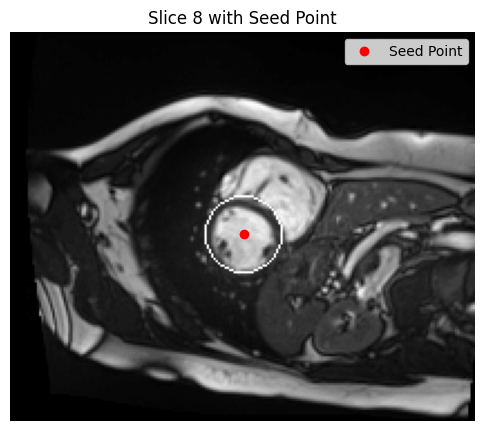

In [19]:
img_ed = nib.load('Dataset/Test/102/102_ED.nii')
img_es = nib.load('Dataset/Test/102/102_ES.nii')
data_ED = img_ed.get_fdata()
data_ES = img_es.get_fdata()

slice_idx, seed, radius = compute_seed_from_ed_es_v2(data_ED, data_ES, case_id=102)
print("Slice index:", slice_idx)
print("Seed point:", seed)
plot_heart_slice_with_seed(data_ED, slice_idx, seed, radius)

Slice index: 4
Seed point: (58, 134)


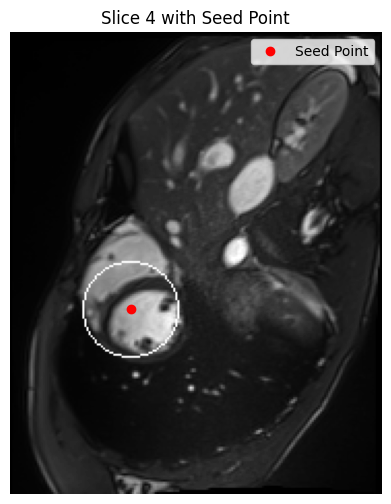

In [20]:
img_ed = nib.load('Dataset/Test/107/107_ED.nii')
img_es = nib.load('Dataset/Test/107/107_ES.nii')
data_ED = img_ed.get_fdata()
data_ES = img_es.get_fdata()

slice_idx, seed, radius = compute_seed_from_ed_es_v2(data_ED, data_ES, case_id=107)
print("Slice index:", slice_idx)
print("Seed point:", seed)
plot_heart_slice_with_seed(data_ED, slice_idx, seed, radius)

**Multiple circles selection**

In [21]:
def compute_seed_from_ed_es_v3(data_ED, data_ES, hough_radii_range=(13, 50), case_id=None, num_peaks=3):
    """
    Compute up to `num_peaks` candidate seed circles from the same slice in ED and ES 3D images.
    Uses CLAHE adaptively if intensity stats are abnormal.
    
    Returns:
        slice_idx: index of the used slice.
        circles: list of (x, y, radius) tuples for the top Hough circles.
    """
    slice_idx = data_ED.shape[2] // 2
    slice_ED = data_ED[:, :, slice_idx]
    slice_ES = data_ES[:, :, slice_idx]

    # Difference image
    diff_image = np.abs(slice_ED - slice_ES)
    diff_image = (diff_image - diff_image.min()) / (diff_image.max() - diff_image.min())

    # Edge detection
    edges = canny(diff_image, sigma=2)

    # Hough Transform
    hough_radii = np.arange(hough_radii_range[0], hough_radii_range[1], 2)
    hough_res = hough_circle(edges, hough_radii)
    accums, cx, cy, radii = hough_circle_peaks(hough_res, hough_radii, total_num_peaks=num_peaks)

    # Retornar os círculos encontrados
    circles = []
    for x, y, r in zip(cx, cy, radii):
        circles.append((x, y, r))

    return slice_idx, circles


In [ ]:
def plot_heart_slice_with_circles(data_ED, slice_idx, circles):
    """
    Plota a fatia do coração com múltiplos círculos detectados.
    Cada círculo é representado por (x, y, radius).
    """
    import matplotlib.pyplot as plt
    from skimage.draw import circle_perimeter

    img_slice = data_ED[:, :, slice_idx]
    img_overlay = img_slice.copy()

    fig, ax = plt.subplots(figsize=(6, 6))
    ax.imshow(img_overlay, cmap='gray')
    ax.set_title(f"Slice {slice_idx} with Detected Circles")

    # Cores diferentes para cada círculo
    colors = ['r', 'g', 'b', 'y', 'c', 'm']

    for i, (x, y, r) in enumerate(circles):
        cx, cy = int(x), int(y)
        rr, cc = circle_perimeter(cy, cx, int(r), shape=img_slice.shape)
        img_overlay[rr, cc] = img_overlay.max()  # destaca borda
        ax.plot(cx, cy, marker='o', color=colors[i % len(colors)], label=f'Seed {i+1}')

    ax.imshow(img_overlay, cmap='gray')
    ax.legend()
    ax.axis('off')
    plt.show()

    return


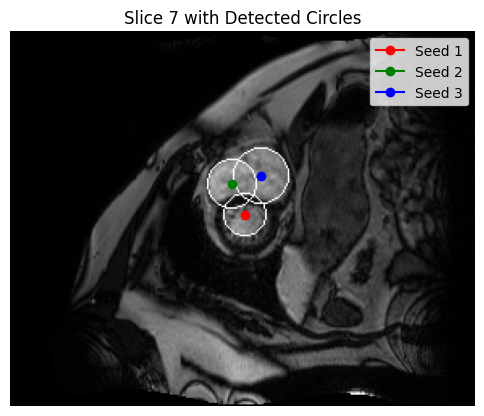

In [23]:
img_ed = nib.load('Dataset/Test/114/114_ED.nii')
img_es = nib.load('Dataset/Test/114/114_ES.nii')
data_ED = img_ed.get_fdata()
data_ES = img_es.get_fdata()

slice_idx, circles = compute_seed_from_ed_es_v3(data_ED, data_ES, case_id=114, num_peaks=3)
plot_heart_slice_with_circles(data_ED, slice_idx, circles)

In [24]:
circles

[(145, 113, 13), (137, 94, 15), (155, 89, 17)]

In [25]:
def select_lowest_circle(circles):
    if not circles:
        return None
    return max(circles, key=lambda c: c[1])  # c[1] = y

Case 101 - ED shape: (216, 256, 8), ES shape: (216, 256, 8)
Case 102 - ED shape: (174, 208, 17), ES shape: (174, 208, 17)
Case 103 - ED shape: (216, 256, 11), ES shape: (216, 256, 11)
Case 104 - ED shape: (216, 256, 8), ES shape: (216, 256, 8)
Case 105 - ED shape: (256, 214, 10), ES shape: (256, 214, 10)
Case 106 - ED shape: (216, 256, 9), ES shape: (216, 256, 9)
Case 107 - ED shape: (224, 180, 8), ES shape: (224, 180, 8)
Case 108 - ED shape: (256, 232, 10), ES shape: (256, 232, 10)
Case 109 - ED shape: (248, 256, 10), ES shape: (248, 256, 10)
Case 110 - ED shape: (216, 256, 9), ES shape: (216, 256, 9)
Case 111 - ED shape: (240, 256, 10), ES shape: (240, 256, 10)
Case 112 - ED shape: (256, 216, 10), ES shape: (256, 216, 10)
Case 113 - ED shape: (216, 256, 10), ES shape: (216, 256, 10)
Case 114 - ED shape: (232, 288, 15), ES shape: (232, 288, 15)
Case 115 - ED shape: (232, 256, 9), ES shape: (232, 256, 9)
Case 116 - ED shape: (256, 216, 10), ES shape: (256, 216, 10)
Case 117 - ED shape:

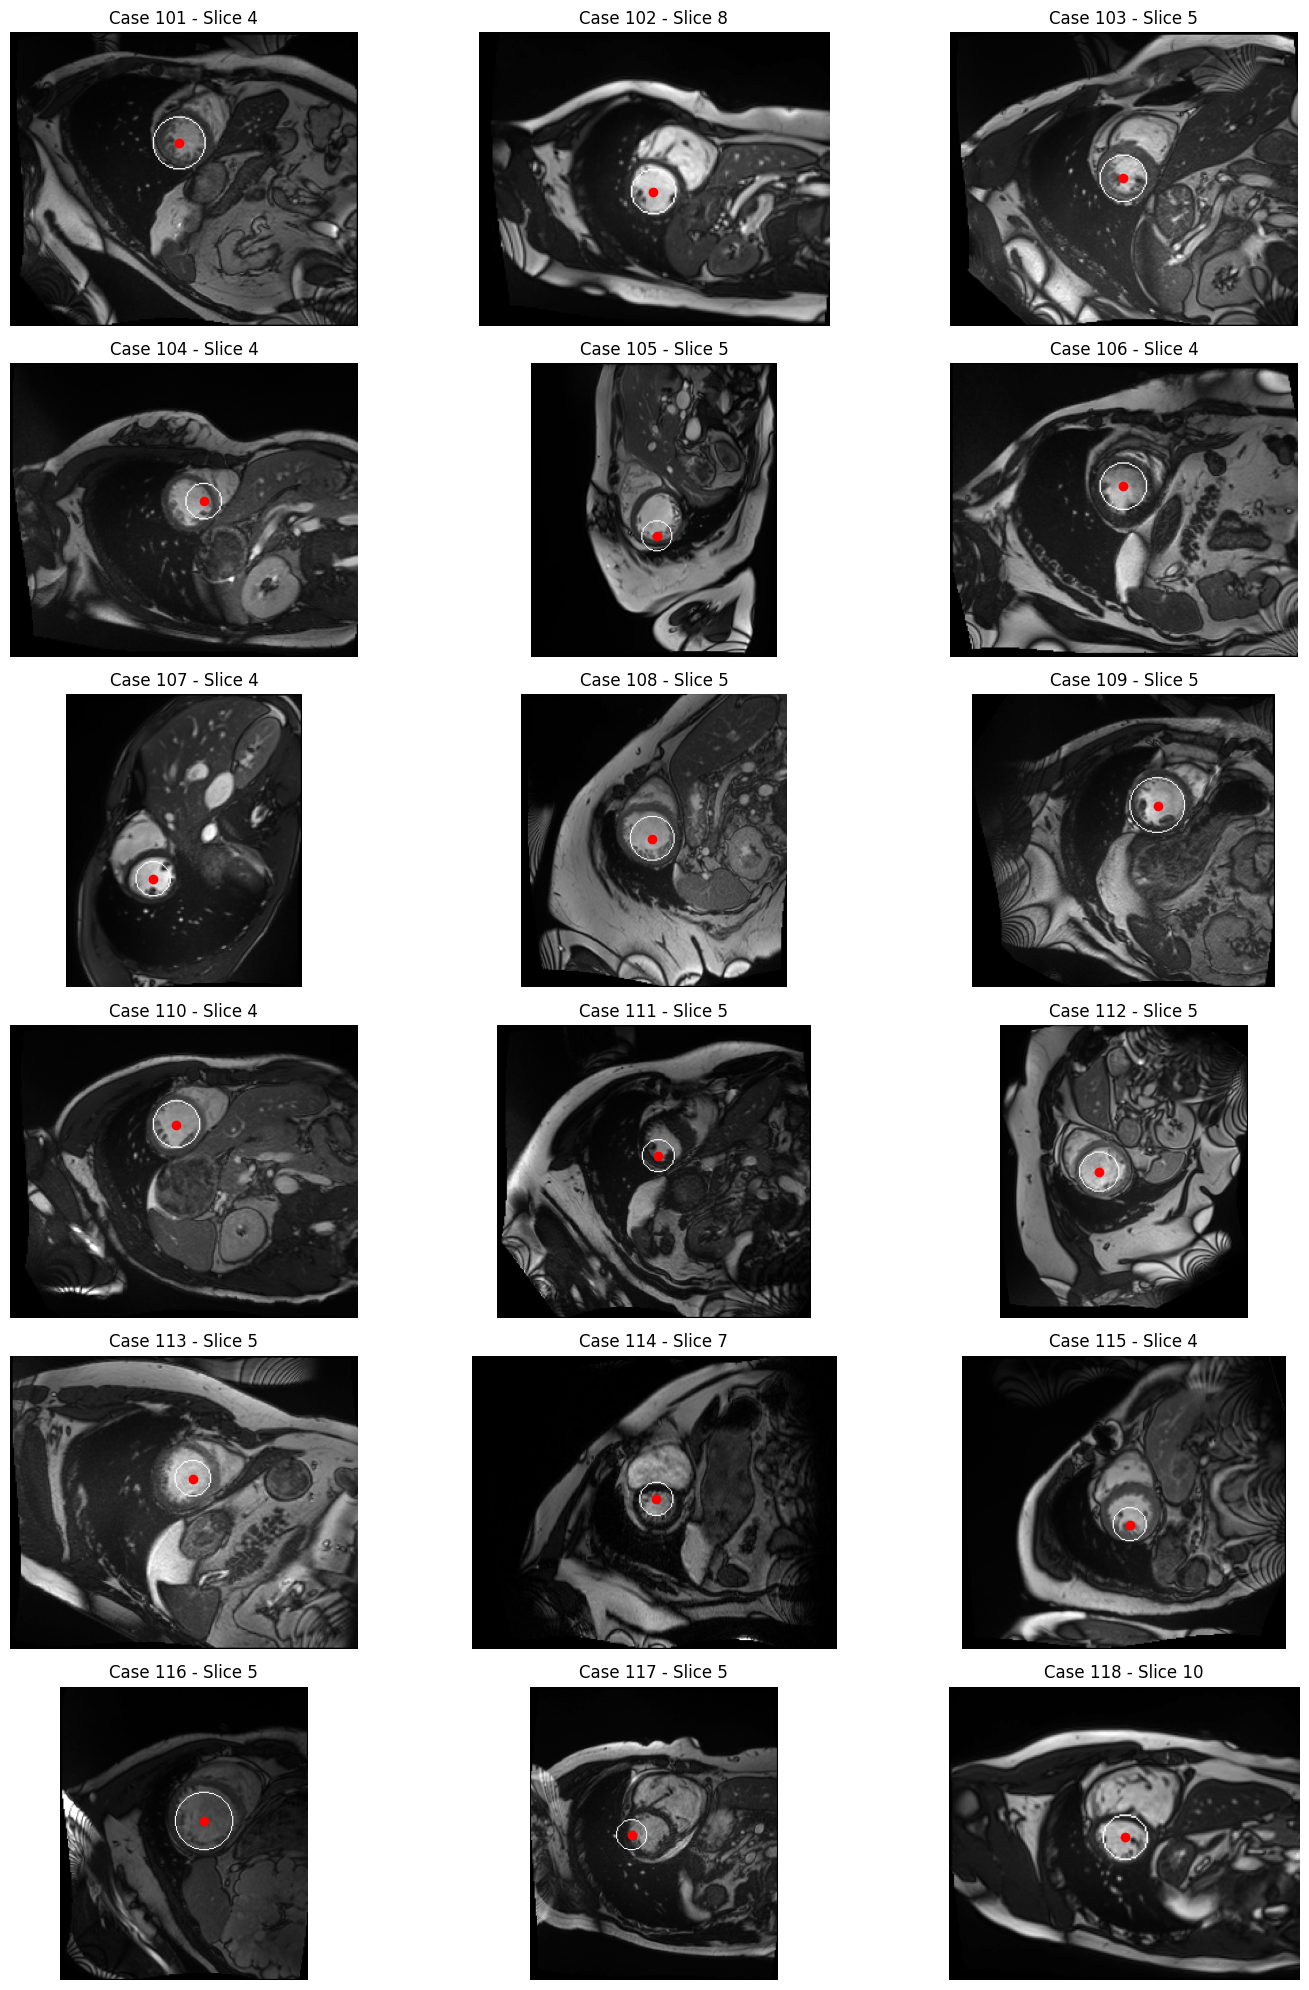

In [26]:
# Plot
fig, axes = plt.subplots(6, 3, figsize=(15, 20))
axes = axes.ravel()

for i, case_id in enumerate(range(101, 119)):
    try:
        img_ed = nib.load(f'Dataset/Test/{case_id}/{case_id}_ED.nii')
        img_es = nib.load(f'Dataset/Test/{case_id}/{case_id}_ES.nii')
        data_ED = img_ed.get_fdata()
        data_ES = img_es.get_fdata()

        # Print shapes
        print(f"Case {case_id} - ED shape: {data_ED.shape}, ES shape: {data_ES.shape}")

        slice_idx, circles = compute_seed_from_ed_es_v3(data_ED, data_ES, case_id=case_id)
        final_seed = select_lowest_circle(circles)
        slice_img = data_ED[:, :, slice_idx]

        axes[i].imshow(slice_img, cmap='gray')
        axes[i].set_title(f"Case {case_id} - Slice {slice_idx}")
        axes[i].axis('off')

        if final_seed is not None:
            cx, cy, r = map(int, final_seed)
            rr, cc = circle_perimeter(cy, cx, r, shape=slice_img.shape)
            slice_img_overlay = slice_img.copy()
            slice_img_overlay[rr, cc] = slice_img_overlay.max()
            axes[i].imshow(slice_img_overlay, cmap='gray')
            axes[i].plot(cx, cy, 'ro')
    except Exception as e:
        axes[i].set_title(f"Case {case_id} - Error")
        axes[i].axis('off')
        print(f"Erro no caso {case_id}: {e}")

plt.tight_layout()
plt.show()


It get the seed really close to the border of lv, but not wrong!

**Radii adaptability**

In [27]:
def compute_seed_from_ed_es_radii_adapt(data_ED, data_ES, hough_radii_range=(13, 50), case_id=None, num_peaks=3):
    """
    Compute up to `num_peaks` candidate seed circles from the same slice in ED and ES 3D images.
    Uses CLAHE adaptively if intensity stats are abnormal.
    
    Returns:
        slice_idx: index of the used slice.
        circles: list of (x, y, radius) tuples for the top Hough circles.
    """
    slice_idx = data_ED.shape[2] // 2
    slice_ED = data_ED[:, :, slice_idx]
    slice_ES = data_ES[:, :, slice_idx]

    # Difference image
    diff_image = np.abs(slice_ED - slice_ES)
    diff_image = (diff_image - diff_image.min()) / (diff_image.max() - diff_image.min())

    h, w = diff_image.shape
    min_dim = min(h, w)
    min_radius = max(13, int(0.07 * h))
    max_radius = 50
    hough_radii = np.arange(min_radius, max_radius, 1)

    # Edge detection
    edges = canny(diff_image, sigma=2)

    # Hough Transform
    #hough_radii = np.arange(hough_radii_range[0], hough_radii_range[1], 2)
    hough_res = hough_circle(edges, hough_radii)
    accums, cx, cy, radii = hough_circle_peaks(hough_res, hough_radii, total_num_peaks=num_peaks)

    # Retornar os círculos encontrados
    circles = []
    for x, y, r in zip(cx, cy, radii):
        circles.append((x, y, r))

    return slice_idx, circles


Case 101 - ED shape: (216, 256, 8), ES shape: (216, 256, 8)
(121, 85, 15)
Case 102 - ED shape: (174, 208, 17), ES shape: (174, 208, 17)
(103, 94, 13)
Case 103 - ED shape: (216, 256, 11), ES shape: (216, 256, 11)
(127, 107, 17)
Case 104 - ED shape: (216, 256, 8), ES shape: (216, 256, 8)
(130, 102, 16)
Case 105 - ED shape: (256, 214, 10), ES shape: (256, 214, 10)
(111, 135, 19)
Case 106 - ED shape: (216, 256, 9), ES shape: (216, 256, 9)
(127, 90, 17)
Case 107 - ED shape: (224, 180, 8), ES shape: (224, 180, 8)
(66, 142, 18)
Case 108 - ED shape: (256, 232, 10), ES shape: (256, 232, 10)
(114, 126, 19)
Case 109 - ED shape: (248, 256, 10), ES shape: (248, 256, 10)
(156, 94, 23)
Case 110 - ED shape: (216, 256, 9), ES shape: (216, 256, 9)
(120, 77, 15)
Case 111 - ED shape: (240, 256, 10), ES shape: (240, 256, 10)
(136, 108, 18)
Case 112 - ED shape: (256, 216, 10), ES shape: (256, 216, 10)
(86, 128, 17)
Case 113 - ED shape: (216, 256, 10), ES shape: (216, 256, 10)
(140, 86, 20)
Case 114 - ED sha

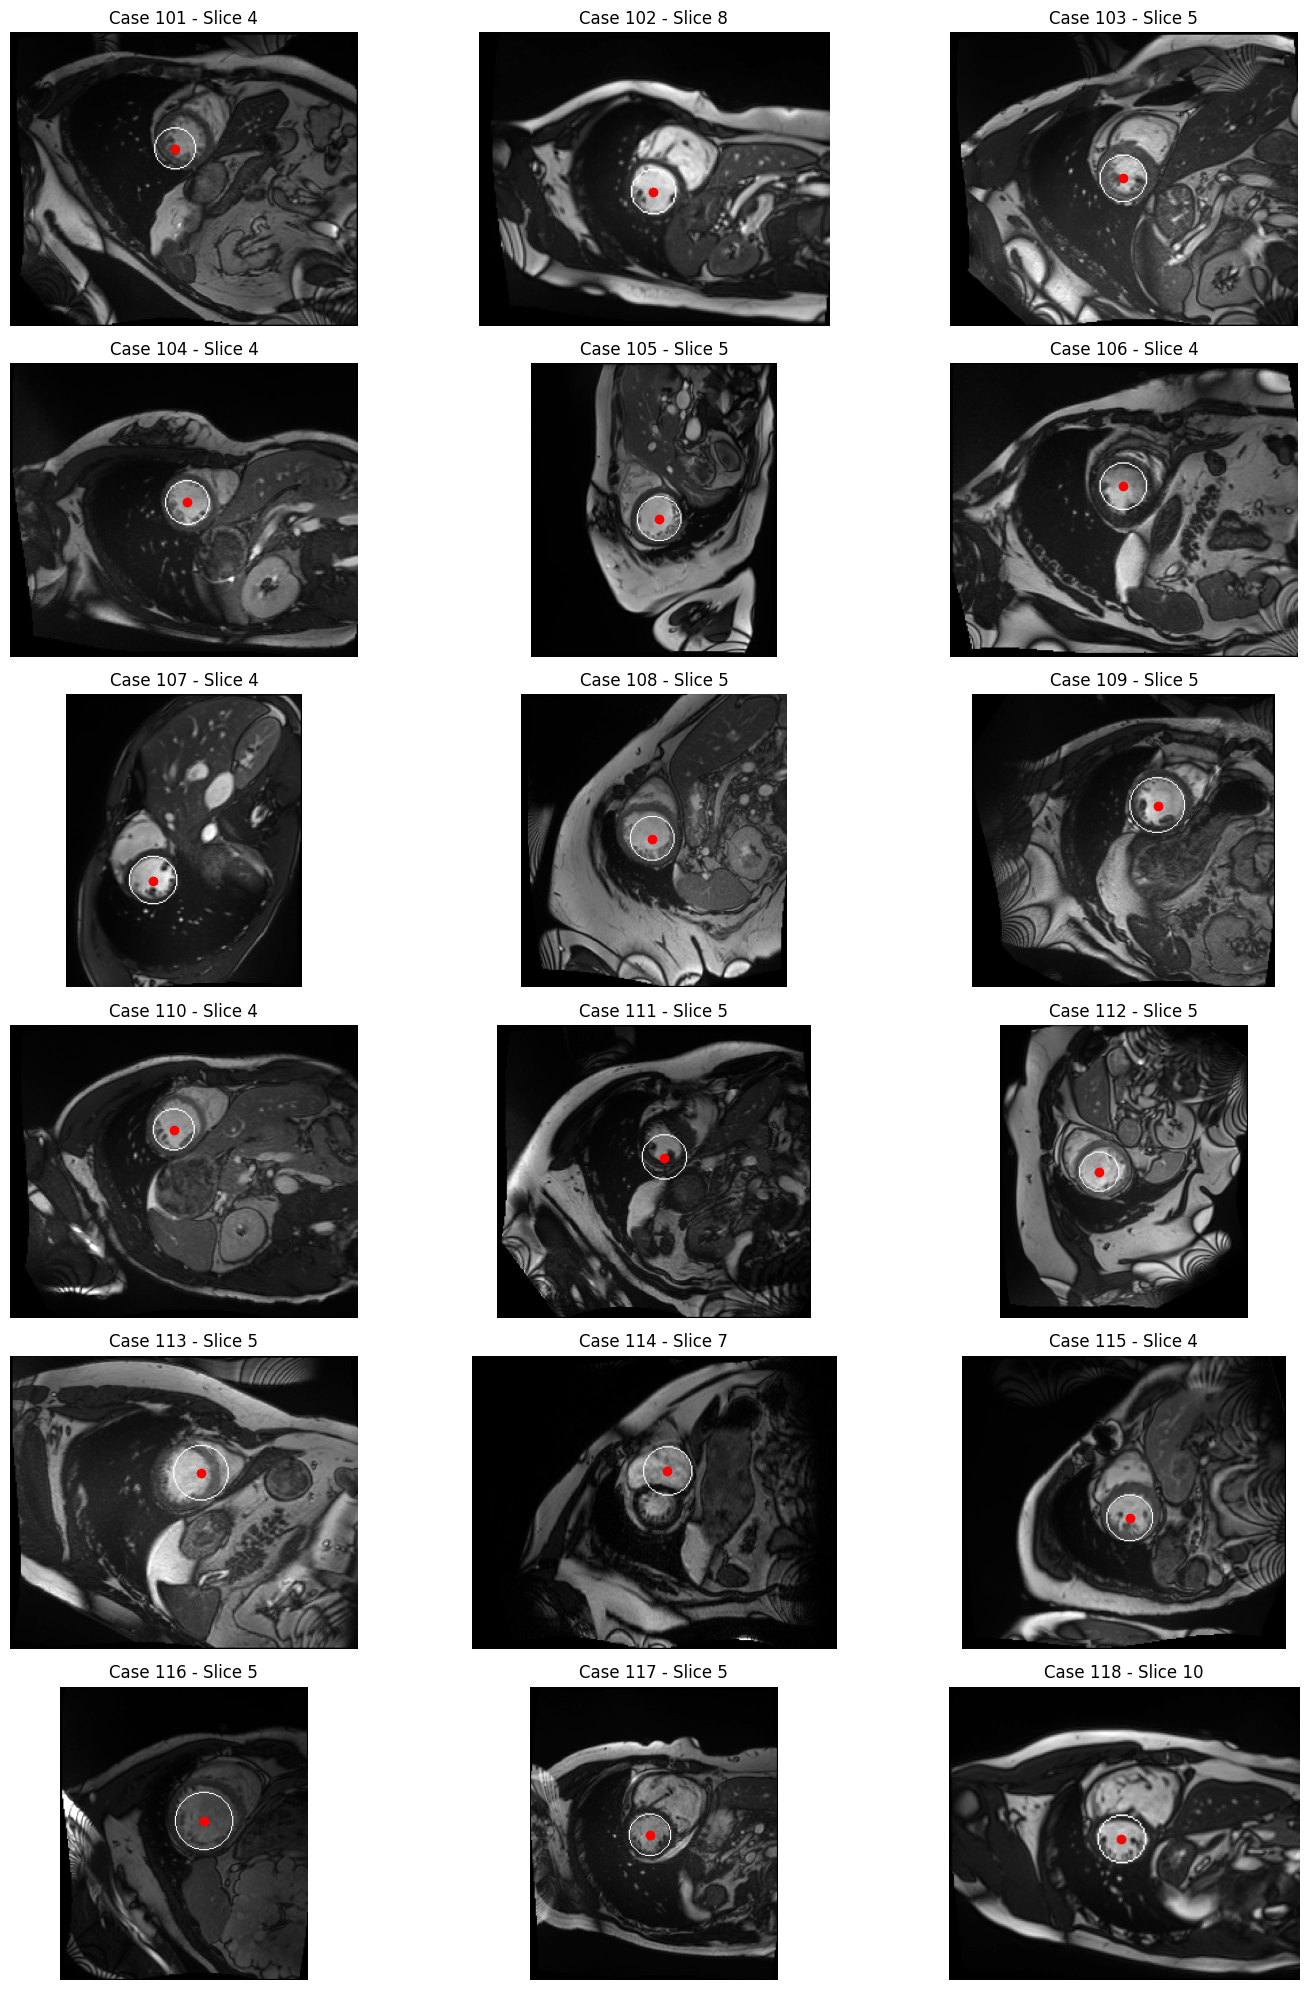

In [28]:
# Plot
fig, axes = plt.subplots(6, 3, figsize=(15, 20))
axes = axes.ravel()

for i, case_id in enumerate(range(101, 119)):
    try:
        img_ed = nib.load(f'Dataset/Test/{case_id}/{case_id}_ED.nii')
        img_es = nib.load(f'Dataset/Test/{case_id}/{case_id}_ES.nii')
        data_ED = img_ed.get_fdata()
        data_ES = img_es.get_fdata()

        # Print shapes
        print(f"Case {case_id} - ED shape: {data_ED.shape}, ES shape: {data_ES.shape}")

        slice_idx, circles = compute_seed_from_ed_es_radii_adapt(data_ED, data_ES, case_id=case_id, num_peaks=4)
        final_seed = select_lowest_circle(circles)
        slice_img = data_ED[:, :, slice_idx]

        axes[i].imshow(slice_img, cmap='gray')
        axes[i].set_title(f"Case {case_id} - Slice {slice_idx}")
        axes[i].axis('off')

        if final_seed is not None:
            print(final_seed)
            cx, cy, r = map(int, final_seed)
            rr, cc = circle_perimeter(cy, cx, r, shape=slice_img.shape)
            slice_img_overlay = slice_img.copy()
            slice_img_overlay[rr, cc] = slice_img_overlay.max()
            axes[i].imshow(slice_img_overlay, cmap='gray')
            axes[i].plot(cx, cy, 'ro')
    except Exception as e:
        axes[i].set_title(f"Case {case_id} - Error")
        axes[i].axis('off')
        print(f"Erro no caso {case_id}: {e}")

plt.tight_layout()
plt.show()


**Other idea: instead of analysing just one slice, use also middle slice+1 and -1**

------

In [42]:

import numpy as np
from skimage.filters import sobel
from scipy.ndimage import binary_fill_holes, label

def region_growing_from_seed(image, seed, max_diff=10):

    h, w = image.shape
    visited = np.zeros_like(image, dtype=bool)
    mask = np.zeros_like(image, dtype=bool)

    x0, y0 = int(seed[0]), int(seed[1])
    region_values = [image[y0, x0]]
    threshold = max_diff

    stack = [(x0, y0)]
    visited[y0, x0] = True
    mask[y0, x0] = True

    # while stack:
    #     x, y = stack.pop()
    #     current_mean = np.mean(region_values)

    #     for dx in [-1, 0, 1]:
    #         for dy in [-1, 0, 1]:
    #             xn, yn = x + dx, y + dy
    #             if 0 <= xn < w and 0 <= yn < h and not visited[yn, xn]:
    #                 intensity = image[yn, xn]
    #                 if abs(intensity - current_mean) <= threshold:
    #                     visited[yn, xn] = True
    #                     mask[yn, xn] = True
    #                     region_values.append(intensity)
    #                     stack.append((xn, yn))

    ##
    step_counter = 0
    exploded = False

    while stack:
        x, y = stack.pop()
        current_mean = np.mean(region_values)

        for dx in [-1, 0, 1]:
            for dy in [-1, 0, 1]:
                xn, yn = x + dx, y + dy
                if 0 <= xn < w and 0 <= yn < h and not visited[yn, xn]:
                    intensity = image[yn, xn]
                    if abs(intensity - current_mean) <= threshold:
                        visited[yn, xn] = True
                        mask[yn, xn] = True
                        region_values.append(intensity)
                        stack.append((xn, yn))

        step_counter += 1
        if step_counter % 100 == 0:
            region_size = np.sum(mask)
            if region_size > 3000:
                print("⚠️  Exploded! Region too large")
                exploded = True
                break
    ##

    # Pós-processamento: preencher buracos e pegar maior componente conexa
    mask = binary_fill_holes(mask)
    labeled_mask, _ = label(mask)
    labels, counts = np.unique(labeled_mask, return_counts=True)

    if len(labels) > 1:
        # Ignora o fundo (label 0) e pega o maior entre os demais
        valid_labels = labels[1:]
        valid_counts = counts[1:]
        largest_label = valid_labels[np.argmax(valid_counts)]
        final_mask = labeled_mask == largest_label
    elif len(labels) == 1 and labels[0] != 0:
        # Apenas uma região válida (sem fundo)
        final_mask = labeled_mask == labels[0]
    else:
        # Nada segmentado de verdade, usar a máscara bruta
        final_mask = mask

    mean_intensity = image[final_mask].mean() if final_mask.any() else 0
    std_intensity = image[final_mask].std() if final_mask.any() else 0

    return final_mask, mean_intensity, std_intensity


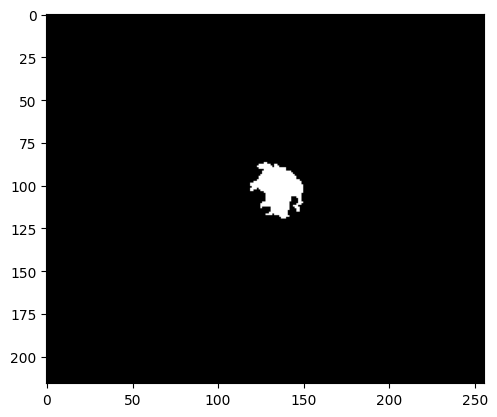

In [46]:
img_ed = nib.load('Dataset/Test/104/104_ED.nii')
img_es = nib.load('Dataset/Test/104/104_ES.nii')
data_ED = img_ed.get_fdata()
data_ES = img_es.get_fdata()

slice_img = data_ED[:, :, 3]
seed = (130, 102)  # seu ponto semente detectado

mask, mu_blood, sigma_blood = region_growing_from_seed(slice_img, seed, max_diff=26)
plt.imshow(mask, cmap='gray')

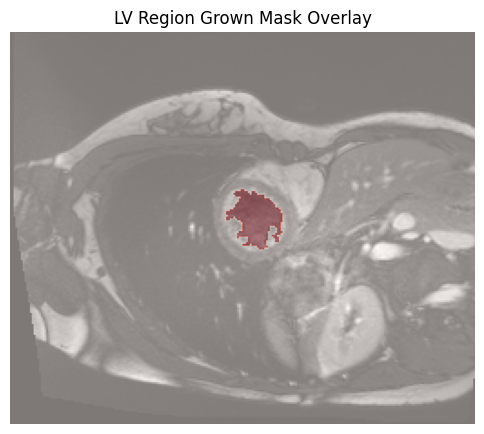

In [31]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
plt.imshow(slice_img, cmap='gray')  # imagem original em tons de cinza
plt.imshow(mask, cmap='Reds', alpha=0.5)  # sobreposição da máscara em vermelho
plt.title("LV Region Grown Mask Overlay")
plt.axis('off')
plt.show()


----

In [32]:
# Reimportar bibliotecas após reset
import numpy as np
from sklearn.linear_model import LinearRegression

def compensate_coil_sensitivity(image, mask):
    """
    Step 3: Fit a planar surface to the intensities of the full-blood region (mask)
    and subtract this bias from the entire image to compensate for coil sensitivity.

    Args:
        image: 2D numpy array (original MR slice)
        mask: 2D boolean numpy array (region of full-blood from step 2)

    Returns:
        corrected_image: 2D numpy array with coil bias corrected
        plane: fitted plane as a 2D array (for visualization/debug if needed)
    """
    y_idx, x_idx = np.where(mask)
    intensities = image[y_idx, x_idx]

    # Features: x, y coordinates
    X = np.column_stack((x_idx, y_idx))  # shape (n_samples, 2)

    # Fit a plane: z = a*x + b*y + c
    model = LinearRegression().fit(X, intensities)
    a, b = model.coef_
    c = model.intercept_

    # Generate the fitted plane over the whole image
    height, width = image.shape
    xx, yy = np.meshgrid(np.arange(width), np.arange(height))
    plane = a * xx + b * yy + c

    # Subtract the fitted plane (bias field) from the image
    corrected_image = image - plane

    return corrected_image, plane


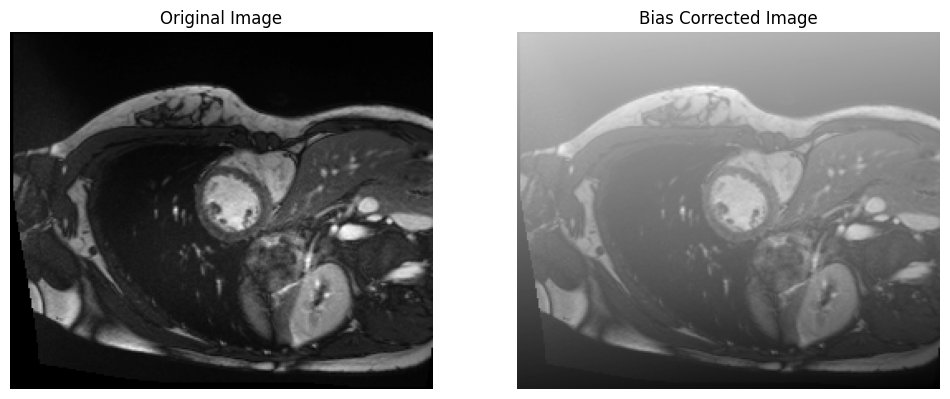

In [33]:
corrected_slice, bias_plane = compensate_coil_sensitivity(slice_img, mask)

# Plot original and corrected images
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(slice_img, cmap='gray')
plt.title("Original Image")
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(corrected_slice, cmap='gray')
plt.title("Bias Corrected Image")
plt.axis('off')
plt.show()

In [43]:
# import morphology
from skimage import morphology as morpho

def estimate_myocardium_mean_using_diff(image, seed, max_diff_list):

    volumes = []
    masks = []
    means = []

    for max_diff in max_diff_list:
        mask, _, _ = region_growing_from_seed(image, seed, max_diff=max_diff)
        volumes.append(np.sum(mask))
        masks.append(mask)
    
        plt.imshow(mask, cmap='gray')
        plt.show()

        print(image[mask].mean())
        means.append(image[mask].mean() if mask.any() else 0)
        if np.sum(mask) > 3000:
            print("Area too large, breaking")
            break

    # Calcular razões de crescimento
    growth_ratios = [volumes[i+1] / volumes[i] if volumes[i] > 0 else 0 for i in range(len(volumes) - 1)]

    # Detectar explosão de volume
    growth_threshold = 2.0
    effusion_idx = next((i for i, r in enumerate(growth_ratios) if r > growth_threshold), len(max_diff_list) - 1)

    best_idx = max(effusion_idx, 0)
    lv_mask = masks[best_idx]

    
    lv_mean = image[lv_mask].mean() if lv_mask.any() else 0
    lv_std = image[lv_mask].std() if lv_mask.any() else 0

    dilated_mask = morpho.binary_dilation(lv_mask, morpho.disk(4))

    dif_mask = dilated_mask & ~lv_mask

    plt.imshow(dif_mask, cmap='gray')
    plt.show()

    myoc_mean = image[dif_mask].mean() if dif_mask.any() else 0
    myoc_std = image[dif_mask].std() if dif_mask.any() else 0

    return lv_mask, lv_mean, lv_std, myoc_mean, myoc_std, masks


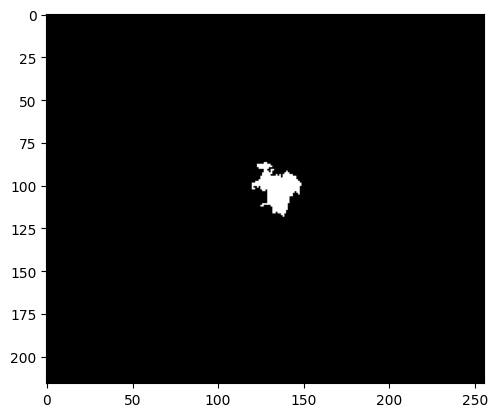

4.1652842354293425


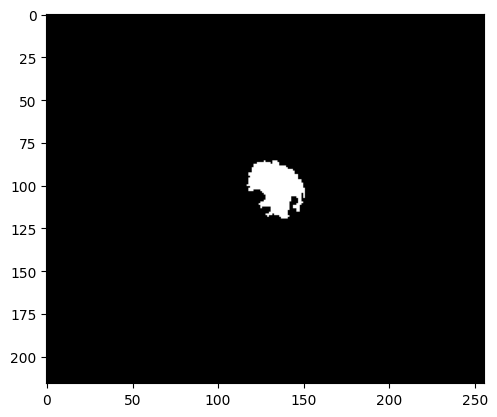

-4.541044789717666


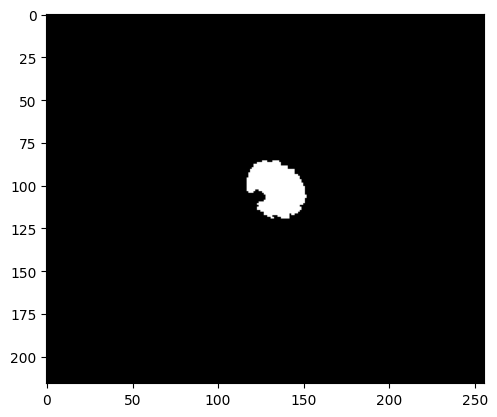

-11.805753066712617


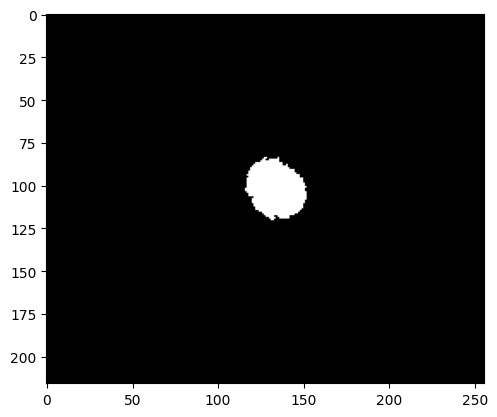

-18.565861599847214
⚠️  Exploded! Region too large


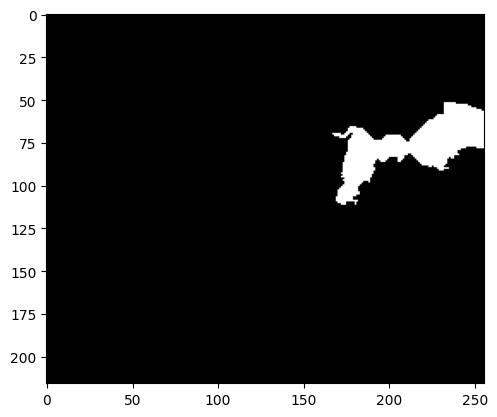

-81.03206497295204


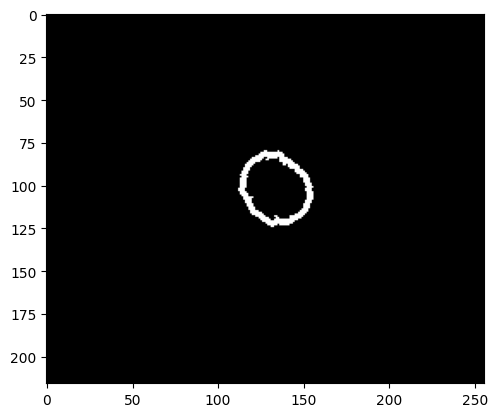

In [44]:
lv_mask, lv_mean, lv_std, myoc_mean, myoc_std, masks = estimate_myocardium_mean_using_diff(corrected_slice, seed, [10, 40, 50, 55, 57])

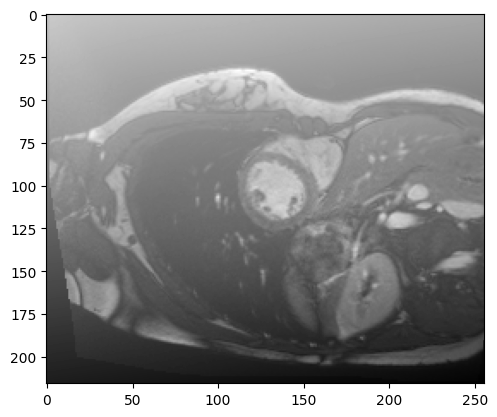

In [ ]:
corrected_slice = corrected_slice - corrected_slice.min()
corrected_slice = corrected_slice / corrected_slice.max()  # agora está entre 0 e 1
corrected_slice = corrected_slice * 255                    # agora entre 0 e 255

plt.imshow(corrected_slice, cmap='gray')

In [ ]:
def normalize_image(image):
    """
    Normalize the image to the range [0, 255].
    """
    image = image - image.min()
    image = image / image.max()
    image = (image * 255)
    return image

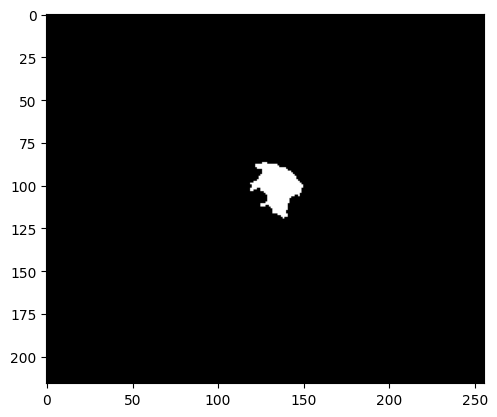

196.2856458826012


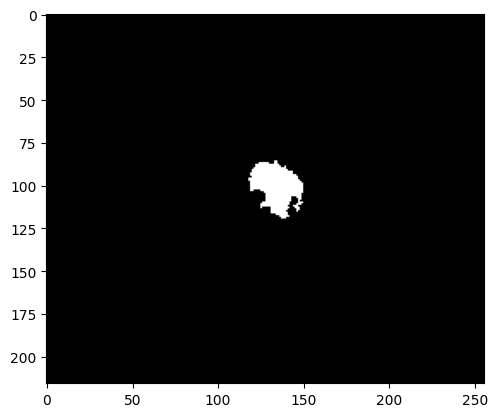

193.52669663664838


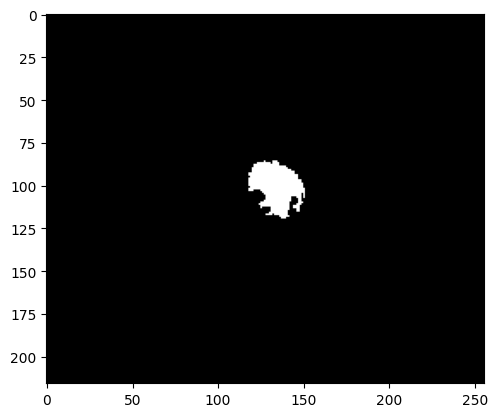

192.00702815453832


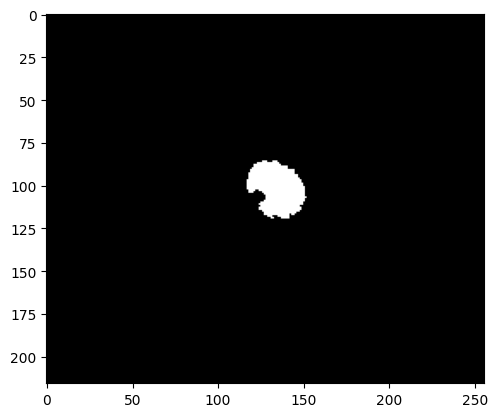

187.6601416179341


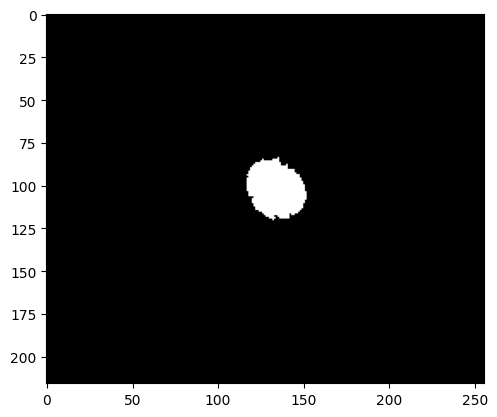

183.42740020446587


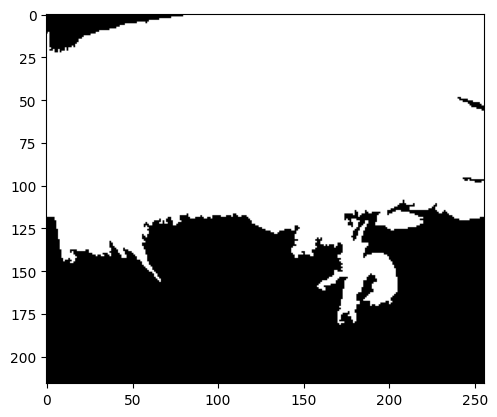

153.84796307536027


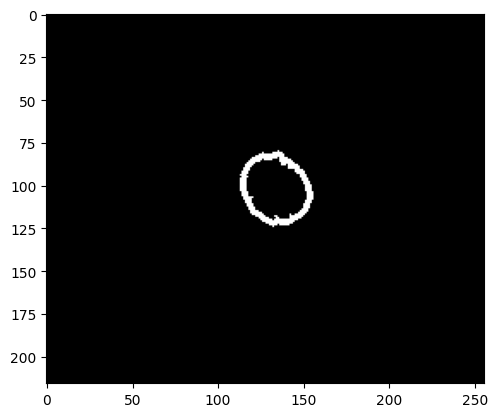

In [ ]:
lv_mask, lv_mean, lv_std, myoc_mean, myoc_std, masks = estimate_myocardium_mean_using_diff(corrected_slice, seed, [10, 20 , 25, 30, 35, 37])

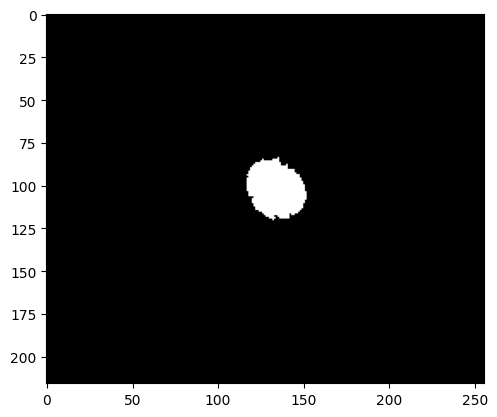

In [ ]:
plt.imshow(lv_mask, cmap='gray')

In [ ]:
myoc_mean

138.47947970536885

In [ ]:
# img_ed = nib.load('Dataset/Test/104/104_ED.nii')
# img_es = nib.load('Dataset/Test/104/104_ES.nii')
# data_ED = img_ed.get_fdata()
# data_ES = img_es.get_fdata()

img_ed_seg = nib.load('Dataset/Test/104/104_ED_seg.nii')
data_ED_seg = img_ed_seg.get_fdata()

slice_img_seg = data_ED_seg[:, :, 3]

# Calculate the mean of corrected image where slice_img_seg == 2
mean_intensity = corrected_slice[slice_img_seg == 2].mean()
mean_intensity

135.40062522883136

In [ ]:
def abs_threshold_region_growing(image, seed, abs_threshold):

    h, w = image.shape
    visited = np.zeros_like(image, dtype=bool)
    mask = np.zeros_like(image, dtype=bool)

    x0, y0 = int(seed[0]), int(seed[1])

    stack = [(x0, y0)]
    visited[y0, x0] = True
    mask[y0, x0] = True

    while stack:
        x, y = stack.pop()
        for dx in [-1, 0, 1]:
            for dy in [-1, 0, 1]:
                xn, yn = x + dx, y + dy
                if 0 <= xn < w and 0 <= yn < h and not visited[yn, xn]:
                    intensity = image[yn, xn]
                    if intensity >= abs_threshold:
                        visited[yn, xn] = True
                        mask[yn, xn] = True
                        stack.append((xn, yn))

    # Pós-processamento: preencher buracos e pegar maior componente conexa
    mask = binary_fill_holes(mask)
    labeled_mask, _ = label(mask)
    labels, counts = np.unique(labeled_mask, return_counts=True)

    if len(labels) > 1:
        # Ignora o fundo (label 0) e pega o maior entre os demais
        valid_labels = labels[1:]
        valid_counts = counts[1:]
        largest_label = valid_labels[np.argmax(valid_counts)]
        final_mask = labeled_mask == largest_label
    elif len(labels) == 1 and labels[0] != 0:
        # Apenas uma região válida (sem fundo)
        final_mask = labeled_mask == labels[0]
    else:
        # Nada segmentado de verdade, usar a máscara bruta
        final_mask = mask

    mean_intensity = image[final_mask].mean() if final_mask.any() else 0
    std_intensity = image[final_mask].std() if final_mask.any() else 0

    return final_mask


In [ ]:
lv_std

18.481173802939683

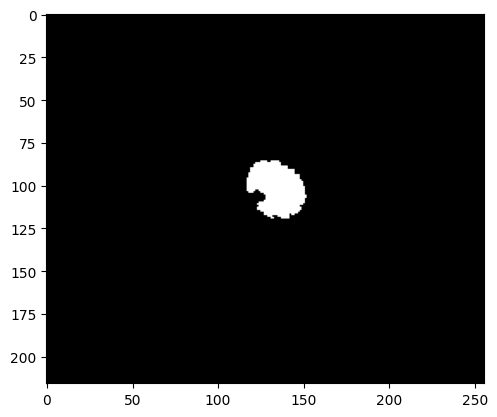

In [ ]:
mask = abs_threshold_region_growing(corrected_slice, seed, myoc_mean+lv_std)
plt.imshow(mask, cmap='gray')
plt.show()

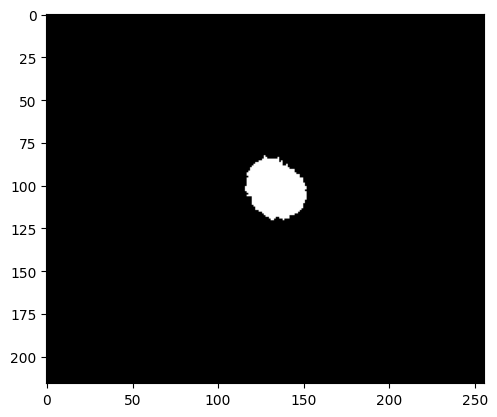

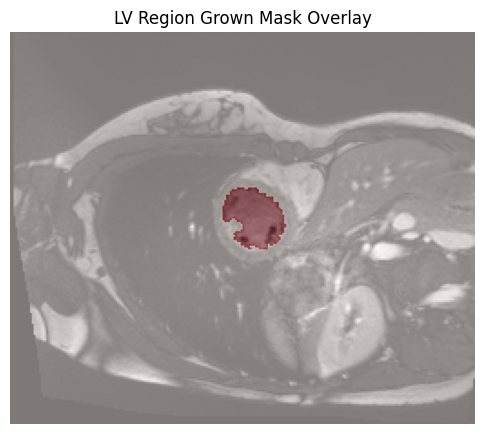

In [ ]:
plt.figure(figsize=(6, 6))
plt.imshow(slice_img, cmap='gray')  # imagem original em tons de cinza
plt.imshow(mask, cmap='Reds', alpha=0.5)  # sobreposição da máscara em vermelho
plt.title("LV Region Grown Mask Overlay")
plt.axis('off')
plt.show()

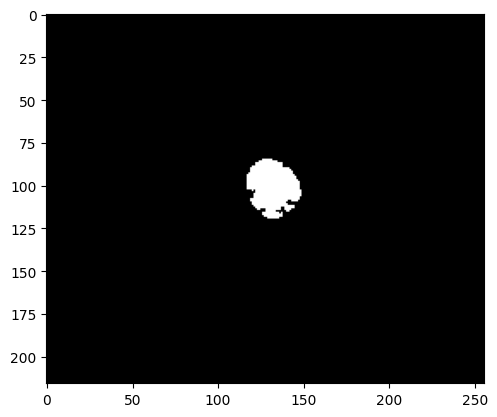

193.30135186261367


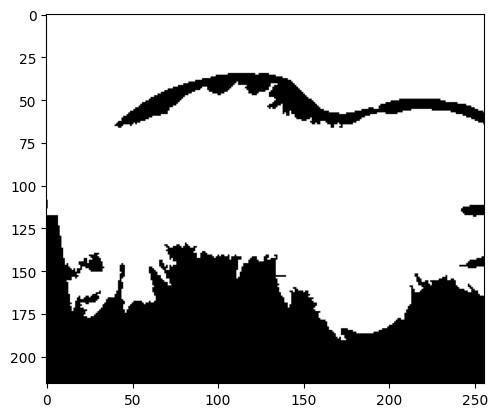

136.59134253878796


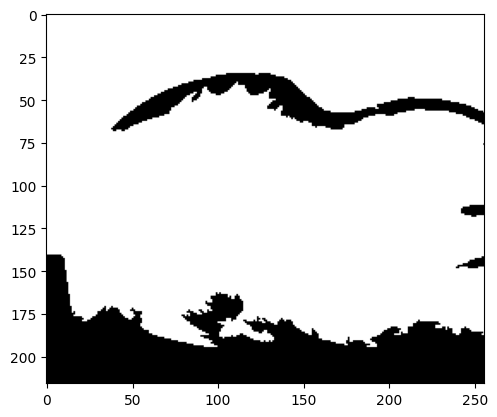

128.09076932685213


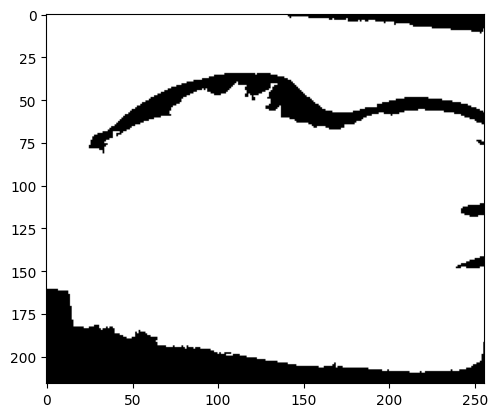

120.86047803660212


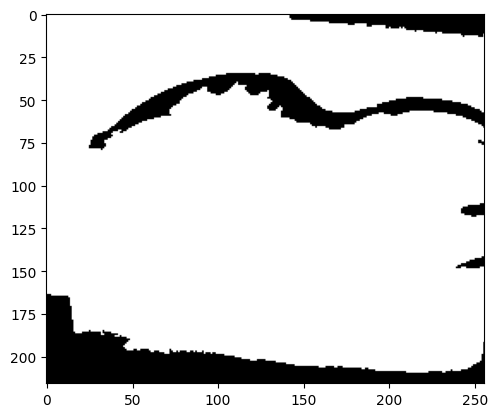

119.8384546711541


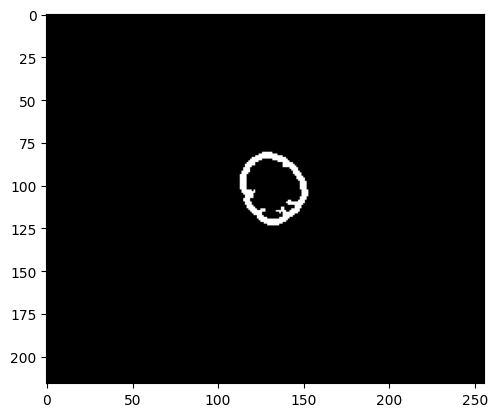

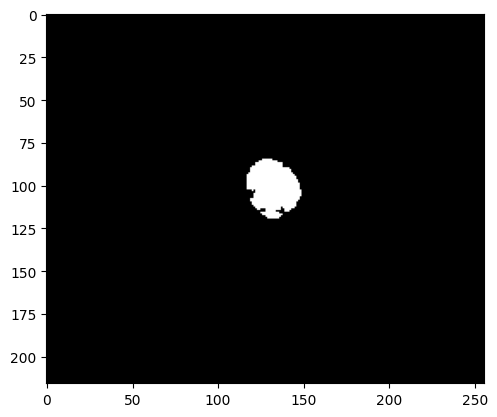

In [ ]:
img_ed_test = nib.load('Dataset/Test/114/114_ED.nii')
img_es_test = nib.load('Dataset/Test/114/114_ES.nii')
data_ED_test = img_ed_test.get_fdata()
data_ES_test = img_es_test.get_fdata()

slice_idx, circles = compute_seed_from_ed_es_v3(data_ED_test, data_ES_test, case_id=114, num_peaks=3)
final_seed = select_lowest_circle(circles)

# plot_heart_slice_with_circles(data_ED_test, slice_idx, circles)
# plot_heart_slice_with_seed(data_ED_test, slice_idx, final_seed, circles[0][2])


slice_img = data_ED_test[:, :, slice_idx]
mask, mu_blood, sigma_blood = region_growing_from_seed(slice_img, seed, max_diff=26)


# plt.imshow(mask, cmap='gray')
# plt.show()

corrected_slice, bias_plane = compensate_coil_sensitivity(slice_img, mask)
corrected_slice = normalize_image(corrected_slice)

# plt.imgshow(corrected_slice, cmap='gray')
# plt.show()

lv_mask, lv_mean, lv_std, myoc_mean, myoc_std, masks = estimate_myocardium_mean_using_diff(corrected_slice, seed, [40, 50, 55, 57, 60])

mask = abs_threshold_region_growing(corrected_slice, seed, myoc_mean+lv_std)
plt.imshow(mask, cmap='gray')
plt.show()

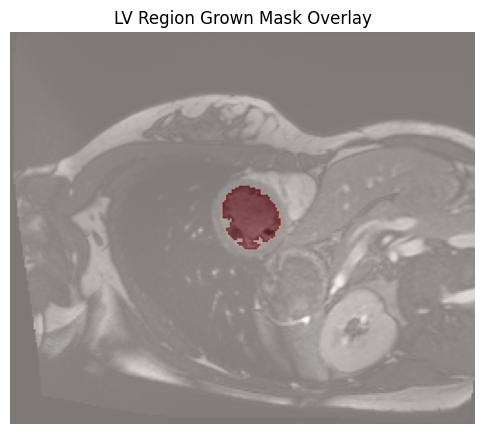

In [ ]:
plt.figure(figsize=(6, 6))
plt.imshow(slice_img, cmap='gray')  # imagem original em tons de cinza
plt.imshow(mask, cmap='Reds', alpha=0.5)  # sobreposição da máscara em vermelho
plt.title("LV Region Grown Mask Overlay")
plt.axis('off')
plt.show()

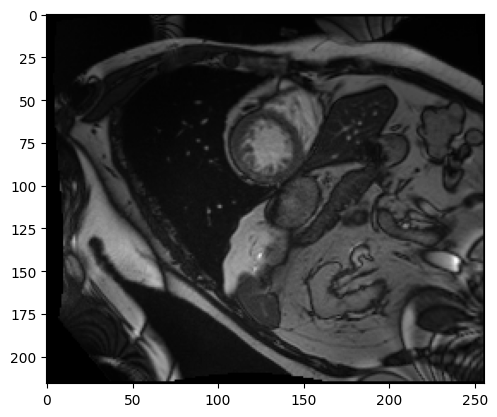

In [ ]:
img_ed_test = nib.load('Dataset/Test/101/101_ED.nii')
img_es_test = nib.load('Dataset/Test/101/101_ES.nii')
data_ED_test = img_ed_test.get_fdata()
data_ES_test = img_es_test.get_fdata()

slice_idx, circles = compute_seed_from_ed_es_v3(data_ED_test, data_ES_test, case_id=101, num_peaks=3)
final_seed = select_lowest_circle(circles)

# plot_heart_slice_with_circles(data_ED_test, slice_idx, circles)
# plot_heart_slice_with_seed(data_ED_test, slice_idx, final_seed, circles[0][2])

slice_img = data_ED_test[:, :, slice_idx]
plt.imshow(slice_img, cmap='gray')

----

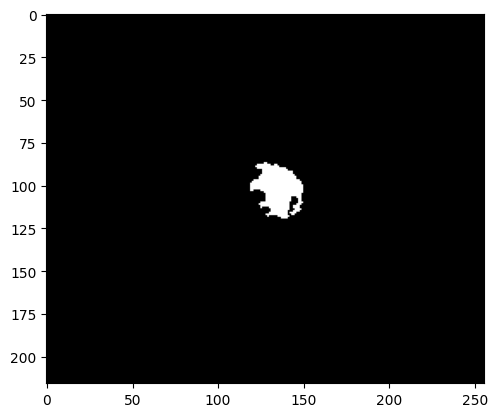

In [ ]:
img_ed = nib.load('Dataset/Test/104/104_ED.nii')
img_es = nib.load('Dataset/Test/104/104_ES.nii')
data_ED = img_ed.get_fdata()
data_ES = img_es.get_fdata()
image_slices = data_ED

slice_img = data_ED[:, :, 3]
seed = (130, 102)  # seu ponto semente detectado

mask, mu_blood, sigma_blood = region_growing_from_seed(slice_img, seed, max_diff=28)
plt.imshow(mask, cmap='gray')